Shape: (10000, 8)
                  Faculty                   Department  UTME_Score  \
0     Management Sciences                      Finance         226   
1  Environmental Sciences  Urban and Regional Planning         224   
2       Clinical Sciences         Medicine and Surgery         218   
3     Veterinary Medicine          Veterinary Medicine         322   
4     Veterinary Medicine          Veterinary Medicine         296   

   Post_UTME_Score  Aggregate_Score  Olevel_Valid  olevel_avg_points  \
0            27.08            69.33             1               2.80   
1             6.76            50.76             1               3.20   
2             7.56            49.61             1               2.96   
3             8.82            65.07             1               3.20   
4             6.93            55.53             1               2.32   

   admitted_numeric  
0                 1  
1                 1  
2                 0  
3                 1  
4                 

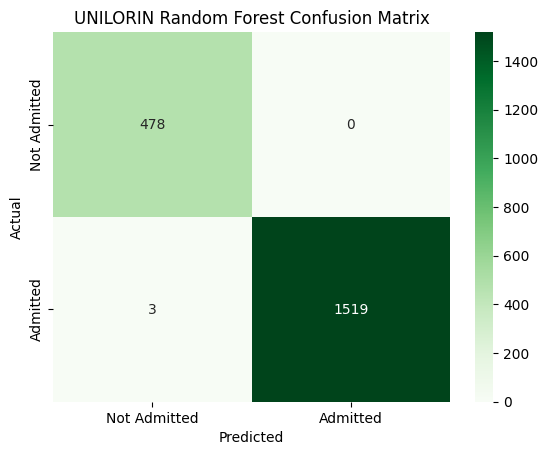

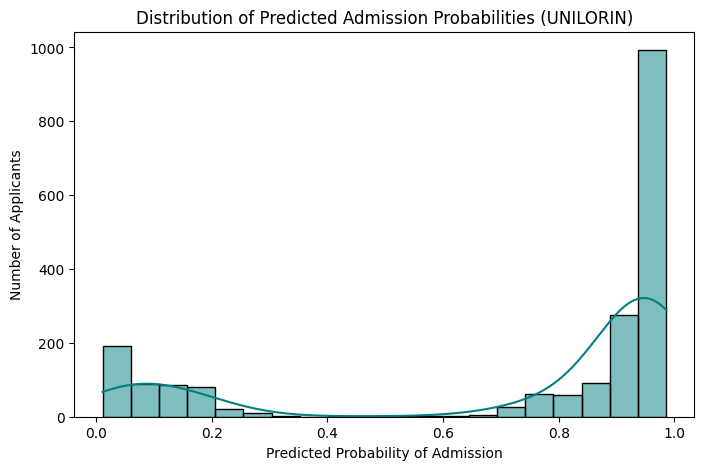


✅ UNILORIN model saved successfully at ../../Models/unilorin_admission_model.pkl


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load processed UNILORIN dataset
unilorin_df = pd.read_csv("../../Data/UNILORIN_processed.csv")
print("Shape:", unilorin_df.shape)
print(unilorin_df.head())

# Check for missing target values
print("\nMissing targets:", unilorin_df['admitted_numeric'].isna().sum())

# Drop rows with missing targets (if any)
unilorin_df = unilorin_df.dropna(subset=['admitted_numeric'])

# Define features (X) and target (y)
X = unilorin_df[['UTME_Score', 'Post_UTME_Score', 'Aggregate_Score',
                 'Faculty', 'Department', 'Olevel_Valid', 'olevel_avg_points']]
y = unilorin_df['admitted_numeric']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)

# Identify categorical and numerical features
categorical_features = ['Faculty', 'Department']
numeric_features = ['UTME_Score', 'Post_UTME_Score', 'Aggregate_Score',
                    'Olevel_Valid', 'olevel_avg_points']

# Preprocessing: OneHotEncode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

# Random Forest Model (with more trees for stability)
random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced',  # balances admitted vs not admitted classes
        max_depth=15
    ))
])

# Train model
random_forest.fit(X_train, y_train)

# Predict probabilities (instead of only class labels)
y_pred_proba = random_forest.predict_proba(X_test)[:, 1]  # probability of admission
y_pred_class = (y_pred_proba >= 0.5).astype(int)  # 0.5 threshold for classification

# Evaluation
print("\nModel Accuracy:", accuracy_score(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

# Example: Show some applicants with their admission probabilities
results_df = X_test.copy()
results_df["Actual_Status"] = y_test.values
results_df["Predicted_Probability"] = y_pred_proba
results_df["Predicted_Status"] = y_pred_class
results_df["Predicted_Chance_%"] = (y_pred_proba * 100).round(2)
print("\nSample predictions with probabilities:")
print(results_df.head(10))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Not Admitted", "Admitted"],
            yticklabels=["Not Admitted", "Admitted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("UNILORIN Random Forest Confusion Matrix")
plt.show()

# Probability Distribution Plot
plt.figure(figsize=(8,5))
sns.histplot(y_pred_proba, bins=20, kde=True, color='teal')
plt.title("Distribution of Predicted Admission Probabilities (UNILORIN)")
plt.xlabel("Predicted Probability of Admission")
plt.ylabel("Number of Applicants")
plt.show()

# Save Model
os.makedirs("../../Models", exist_ok=True)
model_path = "../../Models/unilorin_admission_model.pkl"
joblib.dump(random_forest, model_path)
print(f"\n✅ UNILORIN model saved successfully at {model_path}")
